In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

import gc
import time
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }
train_sample = pd.read_csv("~/environment/mnt/ssd/kaggle-talkingdata2/competition_files/train.csv", skiprows = range(1,122903891), nrows=62000000, dtype=dtypes)
print(train_sample.shape)
train_sample.head()

/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(62000000, 8)


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,304218,12,1,13,245,2017-11-08 16:16:45,NaN,0
1,70656,3,1,19,379,2017-11-08 16:16:45,NaN,0
2,54039,2,1,41,477,2017-11-08 16:16:45,NaN,0
3,258387,9,1,13,232,2017-11-08 16:16:45,NaN,0
4,152156,12,1,15,259,2017-11-08 16:16:45,NaN,0


In [5]:
train_sample.loc[:,"click_time_dt"] = pd.to_datetime(train_sample.loc[:,"click_time"])
train_sample.loc[:,"hour"] = train_sample.loc[:,"click_time_dt"].apply(lambda x: x.hour)
train_sample.loc[:,"day"] = train_sample.loc[:,"click_time_dt"].apply(lambda x: x.day)

print("grouping by ip")
gp = train_sample.groupby(["ip"])["channel"].count().reset_index()
gp.columns = ["ip", "click_by_ip"]
train_sample = pd.merge(train_sample, gp, on="ip", how="left", sort=False)
del gp
gc.collect()

print('grouping by ip-day-hour combination...')
gp = train_sample[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_tcount'})
train_sample = train_sample.merge(gp, on=['ip','day','hour'], how='left')
del gp
gc.collect()

print('grouping by ip-app combination...')
gp = train_sample[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
train_sample = train_sample.merge(gp, on=['ip','app'], how='left')
del gp
gc.collect()

print('grouping by ip-app-os combination...')
gp = train_sample[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
train_sample = train_sample.merge(gp, on=['ip','app', 'os'], how='left')
del gp
gc.collect()

print('grouping by : ip_day_chl_var_hour')
gp = train_sample[['ip','day','hour','channel']].groupby(by=['ip','day','channel'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_tchan_count'})
train_sample = train_sample.merge(gp, on=['ip','day','channel'], how='left')
del gp
gc.collect()

print('grouping by : ip_app_os_var_hour')
gp = train_sample[['ip','app', 'os', 'hour']].groupby(by=['ip', 'app', 'os'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_app_os_var'})
train_sample = train_sample.merge(gp, on=['ip','app', 'os'], how='left')
del gp
gc.collect()

print('grouping by : ip_app_channel_var_day')
gp = train_sample[['ip','app', 'channel', 'day']].groupby(by=['ip', 'app', 'channel'])[['day']].var().reset_index().rename(index=str, columns={'day': 'ip_app_channel_var_day'})
train_sample = train_sample.merge(gp, on=['ip','app', 'channel'], how='left')
del gp
gc.collect()

print('grouping by : ip_app_chl_mean_hour')
gp = train_sample[['ip','app', 'channel','hour']].groupby(by=['ip', 'app', 'channel'])[['hour']].mean().reset_index().rename(index=str, columns={'hour': 'ip_app_channel_mean_hour'})
print("merging...")
train_sample = train_sample.merge(gp, on=['ip','app', 'channel'], how='left')
del gp
gc.collect()

print("vars and data type: ")
train_sample.info()
train_sample['ip_tcount'] = train_sample['ip_tcount'].astype('uint16')
train_sample['ip_app_count'] = train_sample['ip_app_count'].astype('uint16')
train_sample['ip_app_os_count'] = train_sample['ip_app_os_count'].astype('uint16')

print(train_sample.shape)
train_sample.head()

grouping by ip
grouping by ip-day-hour combination...
grouping by ip-app combination...
grouping by ip-app-os combination...
grouping by : ip_day_chl_var_hour
grouping by : ip_app_os_var_hour
grouping by : ip_app_channel_var_day
grouping by : ip_app_chl_mean_hour
merging...
vars and data type: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62000000 entries, 0 to 61999999
Data columns (total 19 columns):
ip                          uint32
app                         uint16
device                      uint16
os                          uint16
channel                     uint16
click_time                  object
attributed_time             object
is_attributed               uint8
click_time_dt               datetime64[ns]
hour                        int64
day                         int64
click_by_ip                 int64
ip_tcount                   int64
ip_app_count                int64
ip_app_os_count             int64
ip_tchan_count              float64
ip_app_os_var              

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_time_dt,hour,day,click_by_ip,ip_tcount,ip_app_count,ip_app_os_count,ip_tchan_count,ip_app_os_var,ip_app_channel_var_day,ip_app_channel_mean_hour
0,304218,12,1,13,245,2017-11-08 16:16:45,NaN,0,2017-11-08 16:16:45,16,8,477,11,106,24,14.250000,16.563406,0.333333,11.250000
1,70656,3,1,19,379,2017-11-08 16:16:45,NaN,0,2017-11-08 16:16:45,16,8,5345,238,811,164,7.780952,42.808133,0.230769,11.222222
2,54039,2,1,41,477,2017-11-08 16:16:45,NaN,0,2017-11-08 16:16:45,16,8,3743,236,316,6,6.809524,21.866667,0.057041,6.176471
3,258387,9,1,13,232,2017-11-08 16:16:45,NaN,0,2017-11-08 16:16:45,16,8,840,39,66,16,24.500000,41.795833,0.194444,10.777778
4,152156,12,1,15,259,2017-11-08 16:16:45,NaN,0,2017-11-08 16:16:45,16,8,806,26,67,2,12.000000,8.000000,0.300000,15.800000


In [6]:
feature = ['app','device','os', 'channel', 'hour', 'day', 
              'ip_tcount', 'ip_tchan_count', 'ip_app_count',
              'ip_app_os_count', 'ip_app_os_var',
              'ip_app_channel_var_day','ip_app_channel_mean_hour']
categorical = ['app', 'device', 'os', 'channel', 'hour', 'day']
target = ["is_attributed"]
X = train_sample.loc[:,feature]
y = train_sample.loc[:,target]
del train_sample
gc.collect()

44

# skAPI

In [10]:
clf = xgb.XGBClassifier()
params = {'max_depth': [3, 5, 10], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 10, 100], 'subsample': [0.8, 0.85, 0.9, 0.95], 'colsample_bytree': [0.5, 1.0], 'n_estimators': [10,50,100]}
clf_cv = GridSearchCV(clf, params, cv=5, scoring = "roc_auc", n_jobs=-1, verbose = 1)

In [11]:
clf_cv.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f28e8356300, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/l...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/ec2-us.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f28e8356300, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/l...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/ec2-us.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'clf_cv.fit(X, y)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 25, 0, 27, 52, 266953, tzinfo=tzlocal()), 'msg_id': '01320583010f4048a1f470e79f481efb', 'msg_type': 'execute_request', 'session': '0e8dafd9fb78440e83f1757e066839a0', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '01320583010f4048a1f470e79f481efb', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'0e8dafd9fb78440e83f1757e066839a0']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'clf_cv.fit(X, y)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 25, 0, 27, 52, 266953, tzinfo=tzlocal()), 'msg_id': '01320583010f4048a1f470e79f481efb', 'msg_type': 'execute_request', 'session': '0e8dafd9fb78440e83f1757e066839a0', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '01320583010f4048a1f470e79f481efb', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'0e8dafd9fb78440e83f1757e066839a0'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'clf_cv.fit(X, y)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 25, 0, 27, 52, 266953, tzinfo=tzlocal()), 'msg_id': '01320583010f4048a1f470e79f481efb', 'msg_type': 'execute_request', 'session': '0e8dafd9fb78440e83f1757e066839a0', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '01320583010f4048a1f470e79f481efb', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='clf_cv.fit(X, y)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'clf_cv.fit(X, y)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('clf_cv.fit(X, y)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('clf_cv.fit(X, y)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='clf_cv.fit(X, y)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-11-35fa7f3e4721>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f28dc03a908, executi..._before_exec=None error_in_exec=None result=None>)
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])
   2855                 code = compiler(mod, cell_name, "single")
-> 2856                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f28ce7a3db0, file "<ipython-input-11-35fa7f3e4721>", line 1>
        result = <ExecutionResult object at 7f28dc03a908, executi..._before_exec=None error_in_exec=None result=None>
   2857                     return True
   2858 
   2859             # Flush softspace
   2860             if softspace(sys.stdout, 0):

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f28ce7a3db0, file "<ipython-input-11-35fa7f3e4721>", line 1>, result=<ExecutionResult object at 7f28dc03a908, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f28ce7a3db0, file "<ipython-input-11-35fa7f3e4721>", line 1>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport xg...\nfrom sklearn.model_selection import GridSearchCV', 'trainsample = pd.read_csv("~/environment/mnt/ssd...00)\nprint(train_sample.shape)\ntrain_sample.head()', 'train_sample = pd.read_csv("~/environment/mnt/ss...00)\nprint(train_sample.shape)\ntrain_sample.head()', 'train_sample.groupby(["ip"])["channel"].count().reset_index()', 'ip_count = train_sample.groupby(["ip"])["channel...se)\nprint(train_sample.shape)\ntrain_sample.head()', 'ip_count = train_sample.groupby(["ip"])["channel...se)\nprint(train_sample.shape)\ntrain_sample.head()', 'feature = ["app","device","os","channel","hour",...ple.loc[:,feature]\ny = train_sample.loc[:,target]', 'clf = xgb.XGBClassifier()\nparams = {\'eta\': 0.3,\n...v=5, scoring = "roc_auc", n_jobs=-1, verbose = 1)', 'clf = xgb.XGBClassifier()\nparams = {\'eta\': [0.3]...v=5, scoring = "roc_auc", n_jobs=-1, verbose = 1)', 'clf = xgb.XGBClassifier()\nparams = {\'eta\': [0.3]...v=5, scoring = "roc_auc", n_jobs=-1, verbose = 1)', 'clf_cv.fit(X, y)'], 'Out': {3:        ip  app  device  os  channel           cl...        0  
3              0  
4              0  , 4:             ip  channel
0            1       47
...14779  364778       16

[114780 rows x 2 columns], 6:        ip  app  device  os  channel           cl... 0          840  
4              0          806  }, 'X':           app  device  os  channel  hour  click_...7   NaN         7544

[62000000 rows x 6 columns], '_':        ip  app  device  os  channel           cl... 0          840  
4              0          806  , '_3':        ip  app  device  os  channel           cl...        0  
3              0  
4              0  , '_4':             ip  channel
0            1       47
...14779  364778       16

[114780 rows x 2 columns], '_6':        ip  app  device  os  channel           cl... 0          840  
4              0          806  , '__':             ip  channel
0            1       47
...14779  364778       16

[114780 rows x 2 columns], '___':        ip  app  device  os  channel           cl...        0  
3              0  
4              0  , ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport xg...\nfrom sklearn.model_selection import GridSearchCV', 'trainsample = pd.read_csv("~/environment/mnt/ssd...00)\nprint(train_sample.shape)\ntrain_sample.head()', 'train_sample = pd.read_csv("~/environment/mnt/ss...00)\nprint(train_sample.shape)\ntrain_sample.head()', 'train_sample.groupby(["ip"])["channel"].count().reset_index()', 'ip_count = train_sample.groupby(["ip"])["channel...se)\nprint(train_sample.shape)\ntrain_sample.head()', 'ip_count = train_sample.groupby(["ip"])["channel...se)\nprint(train_sample.shape)\ntrain_sample.head()', 'feature = ["app","device","os","channel","hour",...ple.loc[:,feature]\ny = train_sample.loc[:,target]', 'clf = xgb.XGBClassifier()\nparams = {\'eta\': 0.3,\n...v=5, scoring = "roc_auc", n_jobs=-1, verbose = 1)', 'clf = xgb.XGBClassifier()\nparams = {\'eta\': [0.3]...v=5, scoring = "roc_auc", n_jobs=-1, verbose = 1)', 'clf = xgb.XGBClassifier()\nparams = {\'eta\': [0.3]...v=5, scoring = "roc_auc", n_jobs=-1, verbose = 1)', 'clf_cv.fit(X, y)'], 'Out': {3:        ip  app  device  os  channel           cl...        0  
3              0  
4              0  , 4:             ip  channel
0            1       47
...14779  364778       16

[114780 rows x 2 columns], 6:        ip  app  device  os  channel           cl... 0          840  
4              0          806  }, 'X':           app  device  os  channel  hour  click_...7   NaN         7544

[62000000 rows x 6 columns], '_':        ip  app  device  os  channel           cl... 0          840  
4              0          806  , '_3':        ip  app  device  os  channel           cl...        0  
3              0  
4              0  , '_4':             ip  channel
0            1       47
...14779  364778       16

[114780 rows x 2 columns], '_6':        ip  app  device  os  channel           cl... 0          840  
4              0          806  , '__':             ip  channel
0            1       47
...14779  364778       16

[114780 rows x 2 columns], '___':        ip  app  device  os  channel           cl...        0  
3              0  
4              0  , ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/ec2-user/environment/<ipython-input-11-35fa7f3e4721> in <module>()
----> 1 clf_cv.fit(X, y)

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...core='warn',
       scoring='roc_auc', verbose=1), X=          app  device  os  channel  hour  click_...7   NaN         7544

[62000000 rows x 6 columns], y=          is_attributed
0                     0
...99999              0

[62000000 rows x 1 columns], groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=5, random_state=None, shuffle=False)>
        X =           app  device  os  channel  hour  click_...7   NaN         7544

[62000000 rows x 6 columns]
        y =           is_attributed
0                     0
...99999              0

[62000000 rows x 1 columns]
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Mar 25 00:28:22 2018
PID: 6925Python 3.6.4: /home/ec2-user/.pyenv/versions/anaconda3-5.1.0/bin/python
...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None,
       silent=True, subsample=1),           app  device  os  channel  hour  click_...7   NaN         7544

[62000000 rows x 6 columns],           is_attributed
0                     0
...99999              0

[62000000 rows x 1 columns], {'score': make_scorer(roc_auc_score, needs_threshold=True)}, memmap([12394373, 12394374, 12394375, ..., 61999997, 61999998, 61999999]), memmap([       0,        1,        2, ..., 14502596, 14502746, 14503262]), 1, {'alpha': 4, 'colsample_bylevel': 0.7, 'colsample_bytree': 0.7, 'eta': 0.3, 'eval_metric': 'auc', 'grow_policy': 'lossguide', 'max_depth': 0, 'max_leaves': 1400, 'min_child_weight': 0, 'nthread': 8, ...}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None,
       silent=True, subsample=1),           app  device  os  channel  hour  click_...7   NaN         7544

[62000000 rows x 6 columns],           is_attributed
0                     0
...99999              0

[62000000 rows x 1 columns], {'score': make_scorer(roc_auc_score, needs_threshold=True)}, memmap([12394373, 12394374, 12394375, ..., 61999997, 61999998, 61999999]), memmap([       0,        1,        2, ..., 14502596, 14502746, 14503262]), 1, {'alpha': 4, 'colsample_bylevel': 0.7, 'colsample_bytree': 0.7, 'eta': 0.3, 'eval_metric': 'auc', 'grow_policy': 'lossguide', 'max_depth': 0, 'max_leaves': 1400, 'min_child_weight': 0, 'nthread': 8, ...})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None,
       silent=True, subsample=1), X=          app  device  os  channel  hour  click_...7   NaN         7544

[62000000 rows x 6 columns], y=          is_attributed
0                     0
...99999              0

[62000000 rows x 1 columns], scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=memmap([12394373, 12394374, 12394375, ..., 61999997, 61999998, 61999999]), test=memmap([       0,        1,        2, ..., 14502596, 14502746, 14503262]), verbose=1, parameters={'alpha': 4, 'colsample_bylevel': 0.7, 'colsample_bytree': 0.7, 'eta': 0.3, 'eval_metric': 'auc', 'grow_policy': 'lossguide', 'max_depth': 0, 'max_leaves': 1400, 'min_child_weight': 0, 'nthread': 8, ...}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    439                       for k, v in fit_params.items()])
    440 
    441     test_scores = {}
    442     train_scores = {}
    443     if parameters is not None:
--> 444         estimator.set_params(**parameters)
        estimator.set_params = <bound method BaseEstimator.set_params of XGBCla...t=1, seed=None,
       silent=True, subsample=1)>
        parameters = {'alpha': 4, 'colsample_bylevel': 0.7, 'colsample_bytree': 0.7, 'eta': 0.3, 'eval_metric': 'auc', 'grow_policy': 'lossguide', 'max_depth': 0, 'max_leaves': 1400, 'min_child_weight': 0, 'nthread': 8, ...}
    445 
    446     start_time = time.time()
    447 
    448     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/base.py in set_params(self=XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None,
       silent=True, subsample=1), **params={'alpha': 4, 'colsample_bylevel': 0.7, 'colsample_bytree': 0.7, 'eta': 0.3, 'eval_metric': 'auc', 'grow_policy': 'lossguide', 'max_depth': 0, 'max_leaves': 1400, 'min_child_weight': 0, 'nthread': 8, ...})
    269             key, delim, sub_key = key.partition('__')
    270             if key not in valid_params:
    271                 raise ValueError('Invalid parameter %s for estimator %s. '
    272                                  'Check the list of available parameters '
    273                                  'with `estimator.get_params().keys()`.' %
--> 274                                  (key, self))
        key = 'alpha'
        self = XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None,
       silent=True, subsample=1)
    275 
    276             if delim:
    277                 nested_params[key][sub_key] = value
    278             else:

ValueError: Invalid parameter alpha for estimator XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1). Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________

In [24]:
clf_cv.cv_results_

/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  wa

{'mean_fit_time': array([0.16906781, 0.16865263, 0.13514185, 0.13555403, 0.61872091,
        0.60411344, 0.58937469, 0.57848525, 1.27095108, 1.23910737,
        1.21446743, 1.173173  , 0.15795531, 0.15562425, 0.15167141,
        0.14641495, 0.76184316, 0.74031925, 0.72591815, 0.71368017,
        1.64069037, 1.61670523, 1.56831026, 1.54427552, 0.16826625,
        0.17084336, 0.16970968, 0.1666091 , 0.9352818 , 0.93884425,
        0.93374434, 0.92107615, 2.18278279, 2.15192332, 2.10163331,
        2.10190096, 0.1669416 , 0.17024689, 0.16966681, 0.16815367,
        0.94751272, 0.95012746, 0.94242525, 0.93850136, 2.21008701,
        2.2092586 , 2.18420296, 2.16343064, 0.13723626, 0.13541775,
        0.13401346, 0.13236585, 0.65146399, 0.62986598, 0.61333785,
        0.6018373 , 1.33788757, 1.29525857, 1.26724739, 1.23731852,
        0.15940509, 0.15368381, 0.15211921, 0.15110831, 0.83154001,
        0.81805387, 0.79441118, 0.78296418, 1.87123504, 1.81289554,
        1.77538285, 1.74241786,

In [26]:
clf_cv.best_score_

0.9621546502562803

In [27]:
clf_cv.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 100,
 'n_estimators': 100,
 'subsample': 0.9}

In [28]:
clf = xgb.XGBClassifier(**clf_cv.best_params_)
clf.fit(X,y)

/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=100, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [30]:
import pickle
pickle.dump(clf, open("model.pkl", "wb"))
clf = pickle.load(open("model.pkl", "rb"))

# https://www.kaggle.com/joaopmpeinado/single-xgboost-lb-0-965/code

In [7]:
dtrain = xgb.DMatrix(X, y)
del X,y
gc.collect()

7

In [8]:
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}
watchlist = [(dtrain, 'train')]

In [9]:
model = xgb.train(params, dtrain, 30, watchlist, maximize=True, verbose_eval=1)

[0]	train-auc:0.959425
[1]	train-auc:0.961626
[2]	train-auc:0.962513
[3]	train-auc:0.96327
[4]	train-auc:0.965163
[5]	train-auc:0.964594
[6]	train-auc:0.96465
[7]	train-auc:0.963278
[8]	train-auc:0.966818
[9]	train-auc:0.967099
[10]	train-auc:0.967386
[11]	train-auc:0.96817
[12]	train-auc:0.969049
[13]	train-auc:0.971388
[14]	train-auc:0.972825
[15]	train-auc:0.973327
[16]	train-auc:0.975027
[17]	train-auc:0.976205
[18]	train-auc:0.977074
[19]	train-auc:0.978184
[20]	train-auc:0.97939
[21]	train-auc:0.980476
[22]	train-auc:0.981802
[23]	train-auc:0.982817
[24]	train-auc:0.983922
[25]	train-auc:0.984949
[26]	train-auc:0.986013
[27]	train-auc:0.98704
[28]	train-auc:0.988012
[29]	train-auc:0.988906


In [10]:
del dtrain
gc.collect()

21

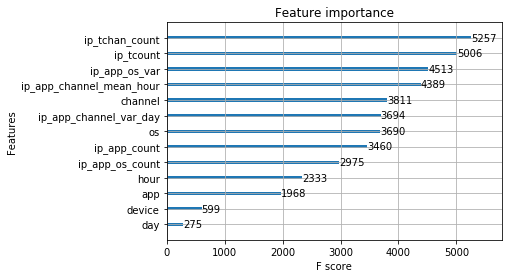

In [11]:
plot_importance(model)
plt.gcf().savefig('feature_importance_xgb.png')

In [12]:
import pickle
pickle.dump(model, open("model.pkl", "wb"))

# 予測

In [13]:
test = pd.read_csv("~/environment/test.csv",dtype=dtypes)
print(test.shape)
test.head()

(18790469, 7)


,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [14]:
test.loc[:,"click_time_dt"] = pd.to_datetime(test.loc[:,"click_time"])
test.loc[:,"hour"] = test.loc[:,"click_time_dt"].apply(lambda x: x.hour)
test.loc[:,"day"] = test.loc[:,"click_time_dt"].apply(lambda x: x.day)

print("grouping by ip")
gp = test.groupby(["ip"])["channel"].count().reset_index()
gp.columns = ["ip", "click_by_ip"]
test = pd.merge(test, gp, on="ip", how="left", sort=False)
del gp
gc.collect()

print('grouping by ip-day-hour combination...')
gp = test[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_tcount'})
test = test.merge(gp, on=['ip','day','hour'], how='left')
del gp
gc.collect()

print('grouping by ip-app combination...')
gp = test[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
test = test.merge(gp, on=['ip','app'], how='left')
del gp
gc.collect()

print('grouping by ip-app-os combination...')
gp = test[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
test = test.merge(gp, on=['ip','app', 'os'], how='left')
del gp
gc.collect()

print('grouping by : ip_day_chl_var_hour')
gp = test[['ip','day','hour','channel']].groupby(by=['ip','day','channel'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_tchan_count'})
test = test.merge(gp, on=['ip','day','channel'], how='left')
del gp
gc.collect()

print('grouping by : ip_app_os_var_hour')
gp = test[['ip','app', 'os', 'hour']].groupby(by=['ip', 'app', 'os'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_app_os_var'})
test = test.merge(gp, on=['ip','app', 'os'], how='left')
del gp
gc.collect()

print('grouping by : ip_app_channel_var_day')
gp = test[['ip','app', 'channel', 'day']].groupby(by=['ip', 'app', 'channel'])[['day']].var().reset_index().rename(index=str, columns={'day': 'ip_app_channel_var_day'})
test = test.merge(gp, on=['ip','app', 'channel'], how='left')
del gp
gc.collect()

print('grouping by : ip_app_chl_mean_hour')
gp = test[['ip','app', 'channel','hour']].groupby(by=['ip', 'app', 'channel'])[['hour']].mean().reset_index().rename(index=str, columns={'hour': 'ip_app_channel_mean_hour'})
print("merging...")
test = test.merge(gp, on=['ip','app', 'channel'], how='left')
del gp
gc.collect()

print("vars and data type: ")
test.info()
test['ip_tcount'] =test['ip_tcount'].astype('uint16')
test['ip_app_count'] = test['ip_app_count'].astype('uint16')
test['ip_app_os_count'] = test['ip_app_os_count'].astype('uint16')

print(test.shape)
test.head()

grouping by ip
grouping by ip-day-hour combination...
grouping by ip-app combination...
grouping by ip-app-os combination...
grouping by : ip_day_chl_var_hour
grouping by : ip_app_os_var_hour
grouping by : ip_app_channel_var_day
grouping by : ip_app_chl_mean_hour
merging...
vars and data type: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18790469 entries, 0 to 18790468
Data columns (total 18 columns):
click_id                    uint32
ip                          uint32
app                         uint16
device                      uint16
os                          uint16
channel                     uint16
click_time                  object
click_time_dt               datetime64[ns]
hour                        int64
day                         int64
click_by_ip                 int64
ip_tcount                   int64
ip_app_count                int64
ip_app_os_count             int64
ip_tchan_count              float64
ip_app_os_var               float64
ip_app_channel_var_day   

,click_id,ip,app,device,os,channel,click_time,click_time_dt,hour,day,click_by_ip,ip_tcount,ip_app_count,ip_app_os_count,ip_tchan_count,ip_app_os_var,ip_app_channel_var_day,ip_app_channel_mean_hour
0,0,5744,9,1,3,107,2017-11-10 04:00:00,2017-11-10 04:00:00,4,10,91,34,28,1,0.333333,NaN,0.0,4.500000
1,1,119901,9,1,3,466,2017-11-10 04:00:00,2017-11-10 04:00:00,4,10,2083,403,289,5,13.130156,4.700000,0.0,8.228571
2,2,72287,21,1,19,128,2017-11-10 04:00:00,2017-11-10 04:00:00,4,10,2135,229,312,24,10.612795,9.027174,0.0,7.969697
3,3,78477,15,1,13,111,2017-11-10 04:00:00,2017-11-10 04:00:00,4,10,1201,239,42,23,0.000000,15.873518,0.0,4.000000
4,4,123080,12,1,13,328,2017-11-10 04:00:00,2017-11-10 04:00:00,4,10,208,60,24,7,0.000000,11.904762,0.0,4.000000


In [15]:
X_test = test.loc[:,feature]
del test
gc.collect()
print(X_test.shape)
X_test.head()

(18790469, 13)


,app,device,os,channel,hour,day,ip_tcount,ip_tchan_count,ip_app_count,ip_app_os_count,ip_app_os_var,ip_app_channel_var_day,ip_app_channel_mean_hour
0,9,1,3,107,4,10,34,0.333333,28,1,NaN,0.0,4.500000
1,9,1,3,466,4,10,403,13.130156,289,5,4.700000,0.0,8.228571
2,21,1,19,128,4,10,229,10.612795,312,24,9.027174,0.0,7.969697
3,15,1,13,111,4,10,239,0.000000,42,23,15.873518,0.0,4.000000
4,12,1,13,328,4,10,60,0.000000,24,7,11.904762,0.0,4.000000


In [16]:
dtest = xgb.DMatrix(X_test)
del X_test
gc.collect()

21

In [17]:
pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)


In [18]:
submission = pd.read_csv("~/environment/sample_submission.csv")
print(submission.shape)
submission.head()

(18790469, 2)


,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [19]:
submission.loc[:,"is_attributed"] = pred
submission.head()

,click_id,is_attributed
0,0,0.013538
1,1,0.002931
2,2,0.000720
3,3,0.019116
4,4,0.001978


In [20]:
submission.to_csv("submission.csv",index=None)

In [21]:
pd.read_csv("submission.csv").head()

,click_id,is_attributed
0,0,0.013538
1,1,0.002931
2,2,0.000720
3,3,0.019116
4,4,0.001978
